<div align='right' style='float: right'>2016-08-10<br />David Wehr</div>
# Basic Text Mining
##### Using Python and Scikit-Learn to perform text classification, using the bag-of-words document model, and a linear SVM classifier

#### Imports

In [25]:
import sqlite3
import re
from collections import Counter, namedtuple
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, cross_validation, metrics, naive_bayes, ensemble, tree
%matplotlib inline

#### Open the SQLite Database
This contains all of our data, in a table called "Reviews", with columns:<br />
Id | ProductId | UserId | ProfileName | HelpfulnessNumerator | HelpfulnessDenominator | Score | Time | Summary | Text

In [2]:
connection = sqlite3.connect('amazon-fine-foods/database_small.sqlite')
cursor = connection.cursor()

#### Custom Review datatype
This will make the code more readable later

In [3]:
Review = namedtuple('Review', ['id', 'text'])

#### Get Reviews
*positive_reviews* will contain all reviews with 4 or 5 stars<br />
*negative_reviews* will contain all reviews with 1 or 2 stars<br />
We put them together into *reviews*, and create a list of *labels*, where 1 means postive, and 0 is negative

In [4]:
cursor.execute('SELECT Id, Text from Reviews WHERE Score > 3 LIMIT 10000')
positive_reviews = list(map(Review._make, cursor.fetchall()))
cursor.execute('SELECT Id, Text from Reviews WHERE Score < 3 LIMIT 10000')
negative_reviews = list(map(Review._make, cursor.fetchall()))
reviews = positive_reviews + negative_reviews
labels = [1]*len(positive_reviews) + [0]*len(negative_reviews)
reviews[0]

Review(id=1, text='I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.')

### Split into test and train sets
This will randomly split our data into $\frac{1}{4}$ testing, $\frac{3}{4}$ training

In [5]:
train_reviews, test_reviews, train_labels, test_labels = cross_validation.train_test_split(reviews, labels, test_size=0.25)

### Bag-of-Words Model
For classifying reviews, we will be using the bag-of-words model. Essentially, treat each paragraph as a list of words, disregarding their order, punctuation, etc.<br/>
This has obvious drawbacks. The order is lost, so the semantics of even simple phrases can get lost. For example, it will treat "I think this food rocks!" nearly the same as "I think this food is rocks..." Two very different meanings. More complex language features, like sarcasm ("I'm so happy I spent $40 on 1lb of coffee that tastes like Folgers!"), don't have a chance of being properly represented. Synonyms are treated as different words, so "bad" and "horrible" are represented as two completely unrelated words.<br />
Despite all these drawbacks, it has proven to be a very successful model for text classification.<br/>
This model can be extended in a number of ways, with varying success:
* Including collocations (multi-word phrases, like "pickup truck")
* Normalization (TF-IDF, or length normalization)
* Word stemming and lemmatization
<br />

#### Tokenization
To faciliate the bag-of-words model, we must first convert a paragraph into a list of words.<br />
We could just split by spaces, but we'll go a step and further convert everything to lowercase and strip out special characters and punctuation.

In [37]:
def tokenize(text):
    text = text.lower()
    # Strip out these characters
    text = re.sub(r'[.:;,!#%()\'<>]', '', text)
    # Replace these characters with spaces
    text = re.sub(r'[\-/\\&]', ' ', text)
    return text.split()

In [38]:
tokenize("Hello, world! (I'm a consumer/reviewer & I like 30% of special-characters)")

['hello',
 'world',
 'im',
 'a',
 'consumer',
 'reviewer',
 'i',
 'like',
 '30',
 'of',
 'special',
 'characters']

#### Create Vocabulary
Most words appear quite infrequently, and so are not likely to contain much reliable prediction power, but slow down computation time. Let's get rid of them.

In [8]:
all_words = itertools.chain.from_iterable(tokenize(review.text) for review in reviews)
word_counts = Counter(all_words)
our_vocab = [word for word, count in word_counts.most_common() if count >= 5]
print("Total unique words: {}".format(len(word_counts)))
print("Our vocabulary size: {}".format(len(our_vocab)))

Total unique words: 39264
Our vocabulary size: 10140


#### Log-log distribution of most common words and number of times they appear
You can see that common words appear exponentially more often than less-common words

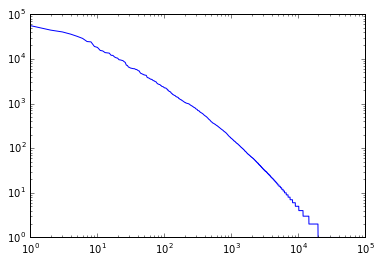

In [9]:
plt.loglog([count for word, count in word_counts.most_common()])

#### Create feature vectors
The scikit-learn library expects inputs to be expressed in a matrix, where each row is a training sample. The row is a vector that describes the sample. In our case, the columns correspond with different words, and the entry is the number of times that word appears.<br />
Let's say our vocabulary is [*tasty*, *gross*, *okay*]<br />
$$\begin{bmatrix}
    2       & 0 & 1 \\
    0       & 1 & 1 \\
    \vdots & \vdots & \vdots & \\
    x_{N1}       & x_{N2} & x_{N3}
\end{bmatrix}$$

In the above example, sample **1** had the word "tasty" appear twice, and the word "okay" appear once, while sample **2** just had the word "gross" appear once.

In [10]:
def reviews_to_matrix(reviews, vocabulary):
    matrix_dims = (len(reviews), len(vocabulary))
    mat = np.zeros(matrix_dims)
    index_lookup = {word: i for i, word in enumerate(vocabulary)}
    for i, review in enumerate(reviews):
        #word_counts = Counter(tokenize(review.text))
        for word in tokenize(review.text):
            idx = index_lookup.get(word)
            if idx is not None: mat[i,idx] += 1
    return mat

In [11]:
train_X = reviews_to_matrix(train_reviews, our_vocab)

### Classification
#### Support Vector Machine
Support vector machines separate the feature space into the two separate classes with a hyperplane.<br/>
See this for a more in-depth explanation of how SVMs work, and their theoretical underpinnings: http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf
<br/><br/>
For our purposes, its good to know that a linear SVM works well for high-dimensional data, such as our word counts (~10,000 dimensions). They work well in terms of both performance and prediction accuracy. For lower-dimensional data, a radial-bias function (RBF) kernel tends to work best for most problems.
#### Other classification algorithms
We could use any supervised machine learning algorithm here, such as:
* Naive Bayes - This has traditionally been used with text classification before the popularity of SVMs
* Decision Tree - On high-dimensional data, they will tend to overfit. This can be mitigated by using ensembles of decision trees, such as the AdaBoost algorithm
* Logistic Regression
* K-Nearest Neighbors
* Multi-layer Perceptron (Neural network)

In [36]:
classifier = svm.LinearSVC(C=1)
#classifier = naive_bayes.MultinomialNB()
#classifier = tree.DecisionTreeClassifier()
#classifier = ensemble.AdaBoostClassifier(n_estimators=10)
classifier.fit(train_X, train_labels)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

#### Make predictions on test set
The test set has not been seen yet by the classifier

In [34]:
test_X = reviews_to_matrix(test_reviews, our_vocab)
test_predictions = classifier.predict(test_X)

#### Evaluate Performance
Accuracy is the ratio of correct predictions to the total number of test samples<br/>
Precision is the ratio of correctly predicted positive reviews to the number of predicted positive reviews<br/>
Recall is the ratio of correctly predicted positive reviews to the total number of positive reviews

In [35]:
accuracy = metrics.accuracy_score(test_labels, test_predictions)
precision = metrics.precision_score(test_labels, test_predictions)
recall = metrics.recall_score(test_labels, test_predictions)
print("Accuracy: {}\nPrecision: {}\nRecall: {}".format(accuracy, precision, recall))

Accuracy: 0.7896
Precision: 0.7676537585421412
Recall: 0.8212835093419983


#### Feature Evaluation
For SVMs, we can see how influential particular words are, and whether they are positive or negative, based on how they influence the hyperplane. Some other classifier algorithms are able to be evaluated in this manner, too.

In [15]:
feature_importances = list(zip(classifier.coef_[0], our_vocab))
feature_importances.sort(key=lambda t: t[0])
print("Positive words:")
print([word for score, word in feature_importances[-20:]])
print("Negative words:")
print([word for score, word in feature_importances[0:20]])

Positive words:
['superb', 'camper', 'lazy', 'neat', 'shattered', 'glad', 'senior', 'houttes', 'yea', 'eco', 'satay', '$400', 'puck', 'refined', 'deliciousbr', 'pricy', 'plockys', 'spike', 'additions', 'smoothest']
Negative words:
['disgusting', 'disappointing', 'revolting', 'canceled', 'horrible', 'manufacturing', 'yuck', 'sickeningly', 'hopes', 'significantly', 'franks', 'hadnt', 'died', 'awful', 'pekoe', 'atleast', 'dead', 'undrinkable', 'explode', 'awesomebr']
